This analysis creates a composite sum score of three UKB phenotypes related to social isolation, and then test the moderating role of social dissatisfaction on brain-by-age relationships:  

For a first pass, we are looking at data from the UKB MRI imaging visit. 


Variable 1: Loneliness/Isolation  

Binary coded (1=Yes, 0=No)

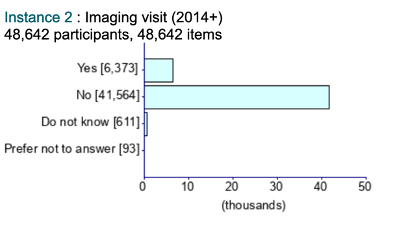
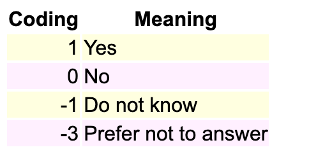

Variable 2: Frequency of friend/family visits
    
Ordinal coding (1-6; positive=less frequent social visits)

Question: "How often do you visit friends or family or have them visit you?"
    
 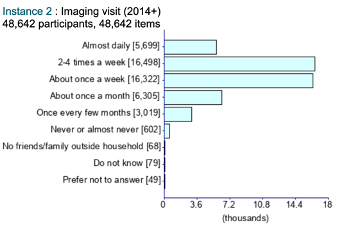
 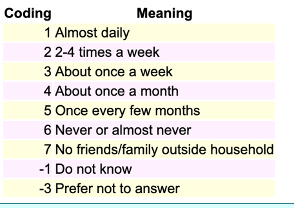

Variable 3: Friendship satisfaction
Ordinal coding (1-7; positive=more dissatisfaction)

Question: "In general how satisfied are you with your FRIENDSHIPS?"

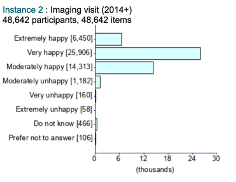
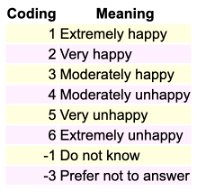

In [107]:
import sqlite3
import pandas as pd
import numpy as np

# connect to the UKB SQL database
db_filename = '/Users/kevinanderson/POSTDOC/PROJECTS/simonsBrainAging/pheweb/generated-by-pheweb/ukb/ukbcc_sqlite3_new.db'
conn = sqlite3.connect(db_filename)
c = conn.cursor()



In [108]:
# fetch variable metadata into a DF
c.execute("SELECT * FROM field_desc")
rows = c.fetchall()
meta_df   = pd.DataFrame(rows)
meta_df.columns = [x[0] for x in c.description]
meta_df.head(3)

,field_num,col_name,field_col,ukb_dtype,pd_type,sql_dtype,field_name,ukb_category,pheno_category,data_coding,tab,covar_type,visit
0,eid,eid,eid,integer,None,None,None,-1,None,None,None,centerSex,None
1,12139,12139_2_0,12139-2.0,Categorical single,object,VARCHAR,Believed safe to perform brain MRI scan,100,Brain MRI,7,str,centerSex,2
2,12139,12139_3_0,12139-3.0,Categorical single,object,VARCHAR,Believed safe to perform brain MRI scan,100,Brain MRI,7,str,centerSex,3


In [109]:
# MRI imaging visit
time = 2


In [110]:
# LONELINESS

# create a DF with loneliness/var
field_num = '1031'
field_name = '{}_{}_0'.format(field_num, time)
cur  = conn.cursor()
cur.execute("SELECT * FROM str WHERE field={} AND time={} AND array=0".format(field_num, time))
rows = cur.fetchall()

# format into a df 
df   = pd.DataFrame(rows)
df.columns = [x[0] for x in cur.description]
df.field = 'CUST_' + df.field
df1031 = df
# remove negative dont know/prefer not to answer
df1031.columns = list(df1031.columns[:-1]) + [field_name]
df1031.loc[df1031[field_name].astype(float) < 0, field_name] = None

# show the df
print(df1031.shape)
df1031.head(3)

(47572, 5)


,eid,field,time,array,1031_2_0
0,1067448,CUST_1031,2,0,None
1,1078125,CUST_1031,2,0,None
2,1111108,CUST_1031,2,0,None


In [111]:
# FREQ OF FRIEND/FAM VISITS

field_num = '4570'
field_name = '{}_{}_0'.format(field_num, time)

cur  = conn.cursor()
cur.execute("SELECT * FROM str WHERE field={} AND time={} AND array=0".format(field_num, time))
rows = cur.fetchall()

# format into a df 
df   = pd.DataFrame(rows)
df.columns = [x[0] for x in cur.description]
df.field = 'CUST_' + df.field
df4570 = df
df4570.columns = list(df4570.columns[:-1]) + [field_name]

# remove negative dont know/prefer not to answer
df4570.loc[df4570[field_name].astype(float) < 0, field_name] = None

# show the df
print(df4570.shape)
df4570.head(3)

(47572, 5)


,eid,field,time,array,4570_2_0
0,1000181,CUST_4570,2,0,None
1,1017649,CUST_4570,2,0,None
2,1020838,CUST_4570,2,0,None


In [112]:
# FRIENDSHIP SATISFACTION

field_num = '2020'
field_name = '{}_{}_0'.format(field_num, time)

cur  = conn.cursor()
cur.execute("SELECT * FROM str WHERE field={} AND time={} AND array=0".format(field_num, time))
rows = cur.fetchall()

# format into a df 
df   = pd.DataFrame(rows)
df.columns = [x[0] for x in cur.description]
df.field = 'CUST_' + df.field
df2020 = df
df2020.columns = list(df2020.columns[:-1]) + [field_name]

# remove negative dont know/prefer not to answer
df2020.loc[df2020[field_name].astype(float) < 0, field_name] = None

# show the df
print(df2020.shape)
df2020.head(3)



(47572, 5)


,eid,field,time,array,2020_2_0
0,1001425,CUST_2020,2,0,None
1,1028181,CUST_2020,2,0,None
2,1029321,CUST_2020,2,0,None


In [113]:
# check the values remaining in each df
print(set(df1031['1031_2_0']))
print(set(df2020['2020_2_0']))
print(set(df4570['4570_2_0']))


{'4.0', '2.0', '1.0', '3.0', '7.0', '5.0', None, '6.0'}
{'0.0', '1.0', None}
{'4.0', '2.0', '1.0', '3.0', '5.0', None, '6.0'}


In [114]:
# convert string to floats
df1031['1031_2_0'] = df1031['1031_2_0'].astype(float)
df2020['2020_2_0'] = df2020['2020_2_0'].astype(float)
df4570['4570_2_0'] = df4570['4570_2_0'].astype(float)

print(set(df1031['1031_2_0'].loc[df1031['1031_2_0'].notna()]))
print(set(df2020['2020_2_0'].loc[df2020['2020_2_0'].notna()]))
print(set(df4570['4570_2_0'].loc[df4570['4570_2_0'].notna()]))

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}
{0.0, 1.0}
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0}


In [115]:
# combine using an outer merge
merge_df = df1031.merge(df2020[['eid', '2020_2_0']], on='eid', how='outer')
merge_df = merge_df.merge(df4570[['eid', '4570_2_0']], on='eid', how='outer')

print(merge_df.shape)
print(merge_df.head(3))


(47572, 7)
       eid      field  time  array  1031_2_0  2020_2_0  4570_2_0
0  1067448  CUST_1031     2      0       NaN       0.0       2.0
1  1078125  CUST_1031     2      0       NaN       0.0       3.0
2  1111108  CUST_1031     2      0       NaN       0.0       2.0


In [116]:
# bound ordinal vars between 0 and 1
merge_df['4570_2_0_div6'] = merge_df['4570_2_0']/6
merge_df['1031_2_0_div7'] = merge_df['1031_2_0']/7

print(set(merge_df['1031_2_0_div7'].loc[merge_df['1031_2_0'].notna()]))
print(set(merge_df['2020_2_0'].loc[merge_df['2020_2_0'].notna()]))
print(set(merge_df['4570_2_0_div6'].loc[merge_df['4570_2_0'].notna()]))

{0.14285714285714285, 0.2857142857142857, 0.5714285714285714, 0.7142857142857143, 0.42857142857142855, 0.8571428571428571, 1.0}
{0.0, 1.0}
{0.3333333333333333, 0.5, 0.6666666666666666, 0.16666666666666666, 1.0, 0.8333333333333334}


In [117]:
# change the field name 
merge_df['field'] = 'CUSTLonely'

# Sum the 3 variables (it will be bounded 0-3)
merge_df['value'] = merge_df[['1031_2_0_div7', '2020_2_0', '4570_2_0_div6']].sum(1)
merge_df.head(10)

,eid,field,time,array,1031_2_0,2020_2_0,4570_2_0,4570_2_0_div6,1031_2_0_div7,value
0,1067448,CUSTLonely,2,0,NaN,0.0,2.0,0.333333,NaN,0.333333
1,1078125,CUSTLonely,2,0,NaN,0.0,3.0,0.500000,NaN,0.500000
2,1111108,CUSTLonely,2,0,NaN,0.0,2.0,0.333333,NaN,0.333333
3,1184046,CUSTLonely,2,0,NaN,0.0,2.0,0.333333,NaN,0.333333
4,1240594,CUSTLonely,2,0,NaN,1.0,3.0,0.500000,NaN,1.500000
5,1243159,CUSTLonely,2,0,NaN,0.0,3.0,0.500000,NaN,0.500000
6,1295940,CUSTLonely,2,0,NaN,0.0,1.0,0.166667,NaN,0.166667
7,1297747,CUSTLonely,2,0,NaN,0.0,3.0,0.500000,NaN,0.500000
8,1305155,CUSTLonely,2,0,NaN,1.0,3.0,0.500000,NaN,1.500000
9,1402263,CUSTLonely,2,0,NaN,NaN,3.0,0.500000,NaN,0.500000


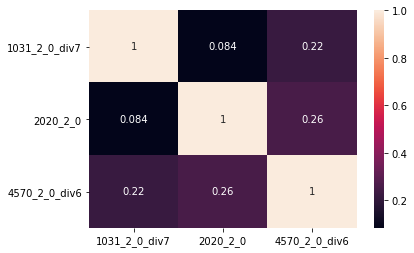

In [118]:
# quick correlation plot of the 3 vars
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = merge_df[['1031_2_0_div7', '2020_2_0', '4570_2_0_div6']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [119]:
# append the new variable to the 'real' SQL data table
print(merge_df[['eid','field','time','array','value']].head())
merge_df[['eid','field','time','array','value']].to_sql('real', con=conn, if_exists='append', index=False)


       eid       field  time  array     value
0  1067448  CUSTLonely     2      0  0.333333
1  1078125  CUSTLonely     2      0  0.500000
2  1111108  CUSTLonely     2      0  0.333333
3  1184046  CUSTLonely     2      0  0.333333
4  1240594  CUSTLonely     2      0  1.500000


In [120]:
# add metadata info for the custom variable

# use loneliness var as example to modify
new_meta = meta_df.loc[meta_df.col_name == '2020_2_0']
new_meta

,field_num,col_name,field_col,ukb_dtype,pd_type,sql_dtype,field_name,ukb_category,pheno_category,data_coding,tab,covar_type,visit
5097,2020,2020_2_0,2020-2.0,Categorical single,object,VARCHAR,"Loneliness, isolation",100060,Mental health,100349,str,centerSex,2


In [121]:
# now change fields to reflect properties of newly create var
pd.options.mode.chained_assignment = None 
new_meta['field_num'] = 'CUSTLonely'
new_meta['col_name'] = 'CUSTLonely_2_0'
new_meta['field_col'] = 'CUSTLonely-2.0'
new_meta['ukb_dtype'] = 'Continuous'
new_meta['sql_dtype'] = 'REAL'
new_meta['field_name'] = 'Composite of 2020/1031/4570'
new_meta['data_coding'] = None
new_meta['tab'] = 'real'


In [122]:
new_meta

,field_num,col_name,field_col,ukb_dtype,pd_type,sql_dtype,field_name,ukb_category,pheno_category,data_coding,tab,covar_type,visit
5097,CUSTLonely,CUSTLonely_2_0,CUSTLonely-2.0,Continuous,object,REAL,Composite of 2020/1031/4570,100060,Mental health,None,real,centerSex,2


In [123]:
# write the metadata DF back to SQL
meta_df = meta_df.append(new_meta)
meta_df.to_sql("field_desc", conn, if_exists='replace', index=False)
conn.commit()


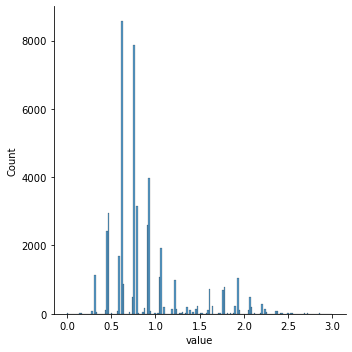

In [124]:
# visualize the composite variable a bit
sn.displot(merge_df, x="value")

In [125]:
merge_df['value'].describe()

count    47572.000000
mean         0.886541
std          0.437380
min          0.000000
25%          0.619048
50%          0.761905
75%          0.928571
max          3.000000
Name: value, dtype: float64

In [129]:
merge_df[['1031_2_0_div7', '4570_2_0_div6', '2020_2_0','value']].isna().sum()

1031_2_0_div7    121
4570_2_0_div6    555
2020_2_0         689
value              0
dtype: int64

In [130]:
merge_df[['1031_2_0_div7', '4570_2_0_div6', '2020_2_0','value']].notna().sum()

1031_2_0_div7    47451
4570_2_0_div6    47017
2020_2_0         46883
value            47572
dtype: int64